In [1]:
import os

project_root = "/Users/nimisha/Desktop/learning/news-reliability-detector/"
os.chdir(project_root)

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt

from src.utils.precision_recall_chart import plot_precision_recall_curve
from src.utils.roc_curve import plot_roc_curve
from src.preprocessing.tokenization import tokenize_data
from src.utils.confusion_matrix import plot_confusion_matrix, get_confusion_matrix
from src.utils.evaluator import evaluate_model

plt.style.use("ggplot")

In [3]:
spark = SparkSession.builder.appName("LogisticRegression").getOrCreate()

24/01/13 15:24:51 WARN Utils: Your hostname, centella.local resolves to a loopback address: 127.0.0.1; using 192.168.1.71 instead (on interface en0)
24/01/13 15:24:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/13 15:24:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/13 15:24:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
train_transformed, test_transformed = tokenize_data(spark)

In [5]:
train_transformed.show(2)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|target|             content|           tokenized|            tfhashed|            features|     features_vector|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|17yearold danish ...|[17yearold, danis...|(100,[0,1,8,14,15...|(100,[0,1,8,14,15...|(100,[0,1,8,14,15...|
|     0|2 hous republican...|[2, hous, republi...|(100,[2,4,5,11,13...|(100,[2,4,5,11,13...|(100,[2,4,5,11,13...|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [6]:
test_transformed.show(2)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|target|             content|           tokenized|            tfhashed|            features|     features_vector|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|460 peopl injur c...|[460, peopl, inju...|(100,[5,6,8,9,12,...|(100,[5,6,8,9,12,...|(100,[5,6,8,9,12,...|
|     0|ackman valeant pl...|[ackman, valeant,...|(100,[0,1,2,3,4,5...|(100,[0,1,2,3,4,5...|[0.87414456771326...|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [7]:
feature_column = "features_vector"
target_column = "target"

## Model Training

In [8]:
lr = LogisticRegression(
    featuresCol=feature_column, labelCol=target_column, predictionCol="prediction"
)

In [9]:
lr_model = lr.fit(train_transformed)

24/01/13 15:25:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/13 15:25:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/01/13 15:25:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Make prediction

In [10]:
training_predictions = lr_model.transform(train_transformed)
test_predictions = lr_model.transform(test_transformed)

# Model Evaluation

### ROC Curve 

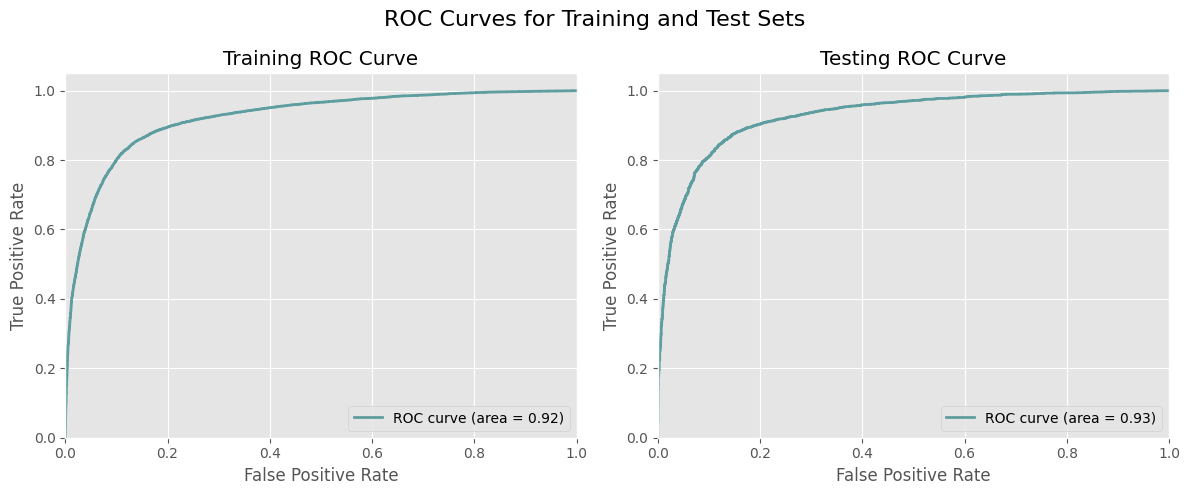

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("ROC Curves for Training and Test Sets", fontsize=16)

plot_roc_curve(axes[0], training_predictions, target_column, "Training")
plot_roc_curve(axes[1], test_predictions, target_column, "Testing")

plt.tight_layout()
plt.show()

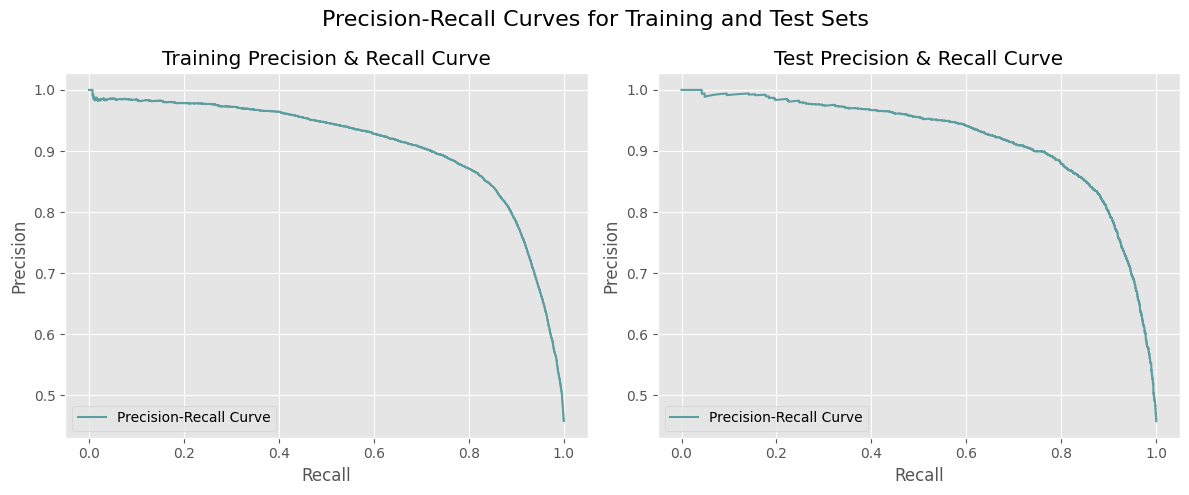

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Precision-Recall Curves for Training and Test Sets", fontsize=16)

plot_precision_recall_curve(axes[0], training_predictions, "target", "Training")
plot_precision_recall_curve(axes[1], test_predictions, "target", "Test")


plt.tight_layout()
plt.show()

In [13]:

train_precision, train_recall, train_accuracy = evaluate_model(
    training_predictions, "target"
)
test_precision, test_recall, test_accuracy = evaluate_model(
    test_predictions, "target"
)

table_data = [
    ["Metric", "Training Set", "Test Set"],
    ["Precision", train_precision, test_precision],
    ["Recall", train_recall, test_recall],
    ["Accuracy", train_accuracy, test_accuracy],
]

for row in table_data:
    print("{:<15} {:<20} {:<20}".format(*row))

Metric          Training Set         Test Set            
Precision       0.8577365212239311   0.8634104005576706  
Recall          0.8578337176530874   0.863486424765288   
Accuracy        0.8578337176530874   0.863486424765288   


In [14]:
train_confusion_matrix = get_confusion_matrix(training_predictions, "target")
test_confusion_matrix = get_confusion_matrix(test_predictions, "target")

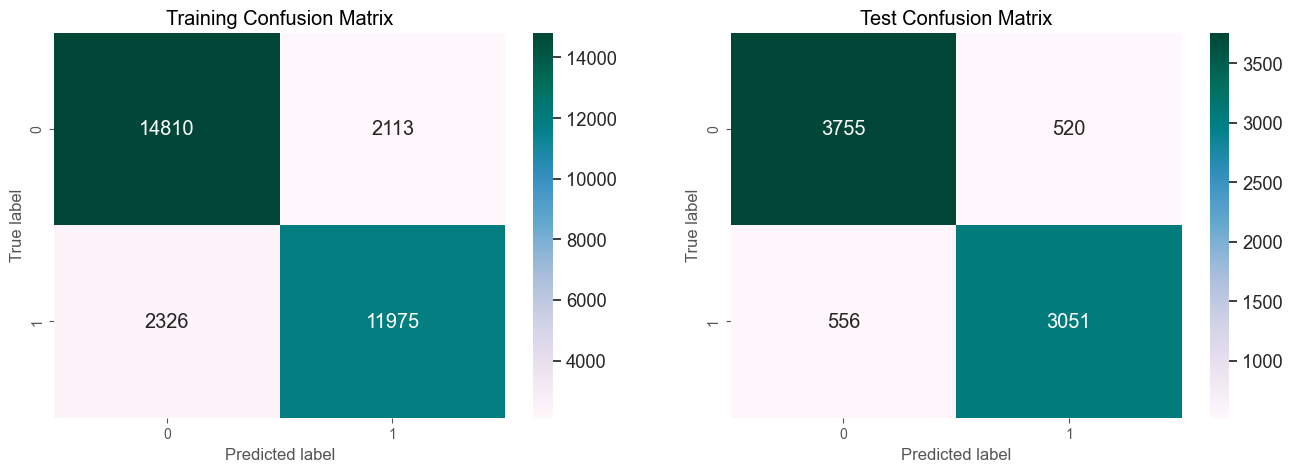

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

classes = [str(label) for label in range(2)]

plot_confusion_matrix(axes[0], train_confusion_matrix, classes, "Training Confusion Matrix")
plot_confusion_matrix(axes[1], test_confusion_matrix, classes, "Test Confusion Matrix")

# Save Model

In [16]:
lr_model.save("models/logistic_regression")